# Libraries

In [3]:
import random

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Subset
from torch.optim import AdamW

from transformers.optimization import get_cosine_schedule_with_warmup
import torch_geometric as pyg
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

/home/leffff/PycharmProjects/misis-ai-course-final-project-2023/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [4]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        # torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        


In [5]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class TrainingConfig:
    # Training
    batch_size = 2048
    epochs = 50
    learning_rate = 1e-2
    lr_warmup_steps = 500

    device = "cuda"
    random_state = 42


config = TrainingConfig()
seed_everything(config.random_state)

# Data

In [6]:
df = pd.read_excel("data/19_35000.xlsx", index_col=0).reset_index(drop=True)
df

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


## Clean

In [7]:
perc = np.percentile(df["IC50"], 96.5)
perc

18.60923999999996

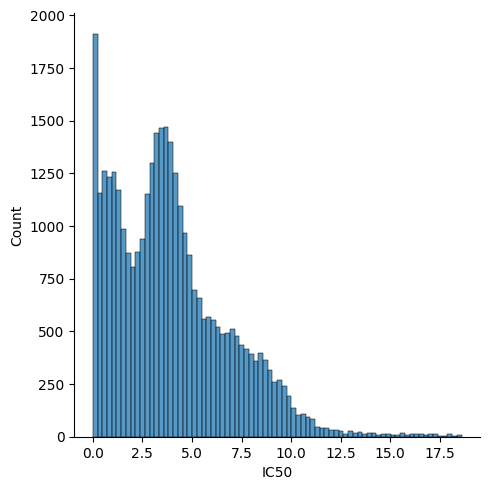

In [8]:
import seaborn as sns
sns.displot(df["IC50"][df["IC50"] <= perc])

In [9]:
df = df[df["IC50"] <= perc]

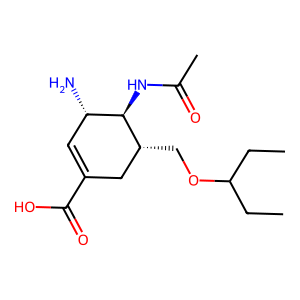

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw

m = Chem.MolFromSmiles(df["SMILES"].tolist()[1])
img = Draw.MolToImage(m)
img

In [11]:
x = pyg.utils.smiles.from_smiles(df["SMILES"].tolist()[1])

In [12]:
class MolDataset(Dataset):
    def __init__(self, df):
        super(MolDataset, self).__init__()
        self.smiles = df["SMILES"].tolist()
        self.target = df["IC50"].tolist()
        
    def __len__(self):
        return len(self.smiles)
        
        
    def __getitem__(self, idx):
        x = pyg.utils.smiles.from_smiles(self.smiles[idx])
        return x, self.target[idx]

In [13]:
train_inds, test_inds = train_test_split(np.arange(df.shape[0]))
train_inds

array([30180, 34316, 16570, ..., 11284,   860, 15795])

In [14]:
dataset = MolDataset(df)

train_loader = DataLoader(
    Subset(dataset, train_inds),
    shuffle=True,
    batch_size=config.batch_size
)

eval_loader = DataLoader(
    Subset(dataset, test_inds),
    shuffle=True,
    batch_size=config.batch_size
)

/home/leffff/PycharmProjects/misis-ai-course-final-project-2023/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [15]:
all_node_features = []
all_edge_features = []

for i in tqdm(range(len(dataset))):
    all_node_features.append(dataset[i][0].x)
    all_edge_features.append(dataset[i][0].edge_attr)

all_node_features = torch.cat(all_node_features, dim=0)
all_edge_features = torch.cat(all_edge_features, dim=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35103/35103 [00:35<00:00, 991.23it/s]


In [16]:
all_node_features.shape

torch.Size([878736, 9])

In [17]:
node_vocab_sizes = []

for i in range(9):
    inds, counts = all_node_features[:, i].unique(return_counts=True)
    print(inds)
    node_vocab_sizes.append(inds.max().item() + 1)

node_vocab_sizes

tensor([ 1,  5,  6,  7,  8,  9, 11, 14, 15, 16, 17, 30, 34, 35, 53])
tensor([0, 1, 2])
tensor([0, 1, 2, 3, 4])
tensor([4, 5, 6, 7])
tensor([0, 1, 2, 3])
tensor([0])
tensor([1, 2, 3, 4])
tensor([0, 1])
tensor([0, 1])


[54, 3, 5, 8, 4, 1, 5, 2, 2]

In [18]:
edge_vocab_sizes = []

for i in range(3):
    inds, counts = all_edge_features[:, i].unique(return_counts=True)
    print(inds)
    edge_vocab_sizes.append(inds.max().item() + 1)

edge_vocab_sizes

tensor([ 1,  2,  3, 12])
tensor([0, 2, 3])
tensor([0, 1])


[13, 4, 2]

# Model

In [19]:
from torch import nn

class RegresisionGNN(torch.nn.Module):
    def __init__(self, node_vocab_sizes, edge_vocab_sizes, backbone, hidden_dim, backbone_dim, pooling_f=global_mean_pool):
        super(RegresisionGNN, self).__init__()
        self.node_vocab_sizes, self.edge_vocab_sizes = node_vocab_sizes, edge_vocab_sizes
        self.node_encoders = nn.ModuleList([nn.Embedding(size, hidden_dim) for size in node_vocab_sizes])
        self.edge_encoders = nn.ModuleList([nn.Embedding(size, hidden_dim) for size in edge_vocab_sizes])
        
        self.backbone = backbone
        self.pooling = pooling_f
        self.out = pyg.nn.Linear(backbone_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = torch.cat([self.node_encoders[i](x[:, i]) for i in range(x.shape[1])], dim=1)
        edge_attr = torch.cat([self.edge_encoders[i](edge_attr[:, i]) for i in range(edge_attr.shape[1])], dim=1)
        
        node_features = self.backbone(
            x=x, 
            edge_index=edge_index, 
            edge_attr=edge_attr
        )

        batch_features = self.pooling(node_features, batch)
        
        return self.out(batch_features)

hidden_dim = 64
backbone = pyg.nn.models.GAT(in_channels=hidden_dim * 9, hidden_channels=hidden_dim * 2, num_layers=8, out_channels=hidden_dim)
model = RegresisionGNN(node_vocab_sizes, edge_vocab_sizes, backbone, hidden_dim=hidden_dim, backbone_dim=hidden_dim)
model

RegresisionGNN(
  (node_encoders): ModuleList(
    (0): Embedding(54, 64)
    (1): Embedding(3, 64)
    (2): Embedding(5, 64)
    (3): Embedding(8, 64)
    (4): Embedding(4, 64)
    (5): Embedding(1, 64)
    (6): Embedding(5, 64)
    (7-8): 2 x Embedding(2, 64)
  )
  (edge_encoders): ModuleList(
    (0): Embedding(13, 64)
    (1): Embedding(4, 64)
    (2): Embedding(2, 64)
  )
  (backbone): GAT(576, 64, num_layers=8)
  (out): Linear(64, 1, bias=True)
)

In [20]:
optimizer = AdamW(model.parameters(), lr=config.learning_rate)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_loader) * config.epochs),
)

loss_function = torch.nn.L1Loss()

# Let's Train

In [21]:
def train_epoch(model, loader, loss_function, optimizer, scheduler, device):
    model.train()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).sigmoid().detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"TRAIN Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}
        
        
def eval_epoch(model, loader, loss_function, device):
    model.eval()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        
        with torch.no_grad():
            output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).sigmoid().detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"EVAL Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}

In [ ]:
train_logs, eval_logs = [], []

for i in range(config.epochs):
    train_log = train_epoch(
        model=model, 
        loader=train_loader, 
        loss_function=loss_function, 
        optimizer=optimizer,
        scheduler=scheduler,
        device=config.device
    )
    
    eval_log = eval_epoch(
        model=model, 
        loader=eval_loader, 
        loss_function=loss_function, 
        device=config.device
    )

    print(train_log, eval_log)
    
    train_logs.append(train_log)
    eval_logs.append(eval_log)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {3.8340923969562235}, 'MAE': {3.4734015464782715}, 'R2': -1.3936500568759573} {'EVAL Loss': {3.428259181976318}, 'MAE': {3.38666033744812}, 'R2': -1.2951836542414967}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {2.7605194862072286}, 'MAE': {3.2127327919006348}, 'R2': -1.1267231779013467} {'EVAL Loss': {2.959074068069458}, 'MAE': {3.1367979049682617}, 'R2': -1.0368442509652804}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


{'TRAIN Loss': {2.4009743470412035}, 'MAE': {3.144059181213379}, 'R2': -1.055461999518824} {'EVAL Loss': {2.283462715148926}, 'MAE': {3.1455187797546387}, 'R2': -1.0461164515977215}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


{'TRAIN Loss': {2.24080281991225}, 'MAE': {3.143326997756958}, 'R2': -1.054748962345451} {'EVAL Loss': {2.241265869140625}, 'MAE': {3.155529260635376}, 'R2': -1.056681980888356}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


{'TRAIN Loss': {2.219804433675913}, 'MAE': {3.1434028148651123}, 'R2': -1.0548596128686052} {'EVAL Loss': {2.2296630859375}, 'MAE': {3.150761604309082}, 'R2': -1.0517997755277033}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


{'TRAIN Loss': {2.2154713043799767}, 'MAE': {3.1445560455322266}, 'R2': -1.0562603696057669} {'EVAL Loss': {2.2570724964141844}, 'MAE': {3.1601929664611816}, 'R2': -1.062145115266686}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {2.2064348000746508}, 'MAE': {3.145014762878418}, 'R2': -1.0572232985778665} {'EVAL Loss': {2.2146088600158693}, 'MAE': {3.1571364402770996}, 'R2': -1.0596389619811473}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.189027877954336}, 'MAE': {3.143913507461548}, 'R2': -1.0566837244698366} {'EVAL Loss': {2.246701192855835}, 'MAE': {3.1648552417755127}, 'R2': -1.069312442449804}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {2.206583151450524}, 'MAE': {3.1427135467529297}, 'R2': -1.0565482008273466} {'EVAL Loss': {2.1926233768463135}, 'MAE': {3.151038408279419}, 'R2': -1.0534261606792081}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {2.1775500040787916}, 'MAE': {3.1433322429656982}, 'R2': -1.0567836364974839} {'EVAL Loss': {2.2112693309783937}, 'MAE': {3.146209239959717}, 'R2': -1.0486154465984603}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


{'TRAIN Loss': {2.1728112514202413}, 'MAE': {3.1421704292297363}, 'R2': -1.0560477273453936} {'EVAL Loss': {2.229667043685913}, 'MAE': {3.144850730895996}, 'R2': -1.0475930164636749}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {2.1784920325646033}, 'MAE': {3.1434545516967773}, 'R2': -1.05744372189446} {'EVAL Loss': {2.220305061340332}, 'MAE': {3.145524740219116}, 'R2': -1.0486271894927244}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


{'TRAIN Loss': {2.179720401763916}, 'MAE': {3.143705368041992}, 'R2': -1.0576575188315434} {'EVAL Loss': {2.1786598205566405}, 'MAE': {3.147510290145874}, 'R2': -1.0506387334765095}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.1802007785210242}, 'MAE': {3.1409642696380615}, 'R2': -1.054741852546349} {'EVAL Loss': {2.217214822769165}, 'MAE': {3.1625523567199707}, 'R2': -1.0675769749736639}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {2.170202090190007}, 'MAE': {3.144186496734619}, 'R2': -1.0583366409978634} {'EVAL Loss': {2.217888116836548}, 'MAE': {3.14664888381958}, 'R2': -1.0498046381014796}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {2.1832956167367787}, 'MAE': {3.1445302963256836}, 'R2': -1.0580585780225342} {'EVAL Loss': {2.19089035987854}, 'MAE': {3.1477231979370117}, 'R2': -1.0510420000626812}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.177892428178054}, 'MAE': {3.14331316947937}, 'R2': -1.0570221971243896} {'EVAL Loss': {2.1932419776916503}, 'MAE': {3.1647539138793945}, 'R2': -1.0692795081508288}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.1758470902076135}, 'MAE': {3.14485239982605}, 'R2': -1.0589461872936785} {'EVAL Loss': {2.171287679672241}, 'MAE': {3.1514410972595215}, 'R2': -1.0545930006241888}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.1681272249955397}, 'MAE': {3.14201283454895}, 'R2': -1.0558002800009616} {'EVAL Loss': {2.178820991516113}, 'MAE': {3.1566402912139893}, 'R2': -1.0613624612513357}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.1735957585848293}, 'MAE': {3.141399621963501}, 'R2': -1.0551532162858206} {'EVAL Loss': {2.2271424770355224}, 'MAE': {3.1450047492980957}, 'R2': -1.048233514165695}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {2.1789948573479285}, 'MAE': {3.143522262573242}, 'R2': -1.0573959863810165} {'EVAL Loss': {2.210606908798218}, 'MAE': {3.163572311401367}, 'R2': -1.0676096105599844}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


{'TRAIN Loss': {2.2034084796905518}, 'MAE': {3.1433045864105225}, 'R2': -1.0570097126320608} {'EVAL Loss': {2.196172523498535}, 'MAE': {3.158012866973877}, 'R2': -1.0609859868739626}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.212987624681913}, 'MAE': {3.1417782306671143}, 'R2': -1.0550973747445669} {'EVAL Loss': {2.2197389602661133}, 'MAE': {3.167172908782959}, 'R2': -1.071355633325242}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.1992726509387674}, 'MAE': {3.1464333534240723}, 'R2': -1.059882183948234} {'EVAL Loss': {2.1732242107391357}, 'MAE': {3.1497886180877686}, 'R2': -1.052230714325097}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


{'TRAIN Loss': {2.191974456493671}, 'MAE': {3.145066499710083}, 'R2': -1.0584693777780227} {'EVAL Loss': {2.1980727195739744}, 'MAE': {3.1475160121917725}, 'R2': -1.0499861197659417}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


{'TRAIN Loss': {2.2004088438474216}, 'MAE': {3.1456122398376465}, 'R2': -1.0585906147678195} {'EVAL Loss': {2.221844959259033}, 'MAE': {3.146693468093872}, 'R2': -1.048925957007202}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.2039440595186672}, 'MAE': {3.145488739013672}, 'R2': -1.0579245686910088} {'EVAL Loss': {2.1870014667510986}, 'MAE': {3.1507110595703125}, 'R2': -1.052053446520238}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {2.17666717676016}, 'MAE': {3.143953323364258}, 'R2': -1.0553529526789691} {'EVAL Loss': {2.1963797092437742}, 'MAE': {3.159027576446533}, 'R2': -1.0605667418708995}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {2.248050653017484}, 'MAE': {3.1460795402526855}, 'R2': -1.0577165035694307} {'EVAL Loss': {2.2747793197631836}, 'MAE': {3.145216464996338}, 'R2': -1.0458741124850892}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {2.2105247240800123}, 'MAE': {3.1444242000579834}, 'R2': -1.0556474905746693} {'EVAL Loss': {2.183080244064331}, 'MAE': {3.1522796154022217}, 'R2': -1.0534047208808603}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


{'TRAIN Loss': {2.221877794999343}, 'MAE': {3.1488611698150635}, 'R2': -1.06126237598854} {'EVAL Loss': {2.182588577270508}, 'MAE': {3.1582999229431152}, 'R2': -1.0603047516881619}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


{'TRAIN Loss': {2.2293993142934947}, 'MAE': {3.147892713546753}, 'R2': -1.0602919642131048} {'EVAL Loss': {2.172911596298218}, 'MAE': {3.1525661945343018}, 'R2': -1.0537680035880603}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


{'TRAIN Loss': {2.2227306916163516}, 'MAE': {3.145894765853882}, 'R2': -1.0571652096363016} {'EVAL Loss': {2.1951076984405518}, 'MAE': {3.155404806137085}, 'R2': -1.0571331784868407}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


{'TRAIN Loss': {2.180184034200815}, 'MAE': {3.143261432647705}, 'R2': -1.055478099144513} {'EVAL Loss': {2.222938871383667}, 'MAE': {3.1661598682403564}, 'R2': -1.0689076863212588}


 23%|█████████████████████████████████████████▊                                                                                                                                           | 3/13 [00:03<00:10,  1.10s/it]